In [1]:
!pip install tensorflow

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNetV3Small
from tensorflow.keras import models, layers, optimizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
import seaborn as sns
import pandas as pd

%matplotlib inline

In [3]:
import tensorflow as tf

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']
# print(get_available_gpus())



Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0



In [11]:
! mkdir ~/.kaggle
!pip install kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [13]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download xhlulu/140k-real-and-fake-faces

100% 3.75G/3.75G [00:34<00:00, 198MB/s]
100% 3.75G/3.75G [00:34<00:00, 116MB/s]


In [15]:
!unzip /content/140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [16]:
import matplotlib.pyplot as plt

In [17]:
pip install matplotlib

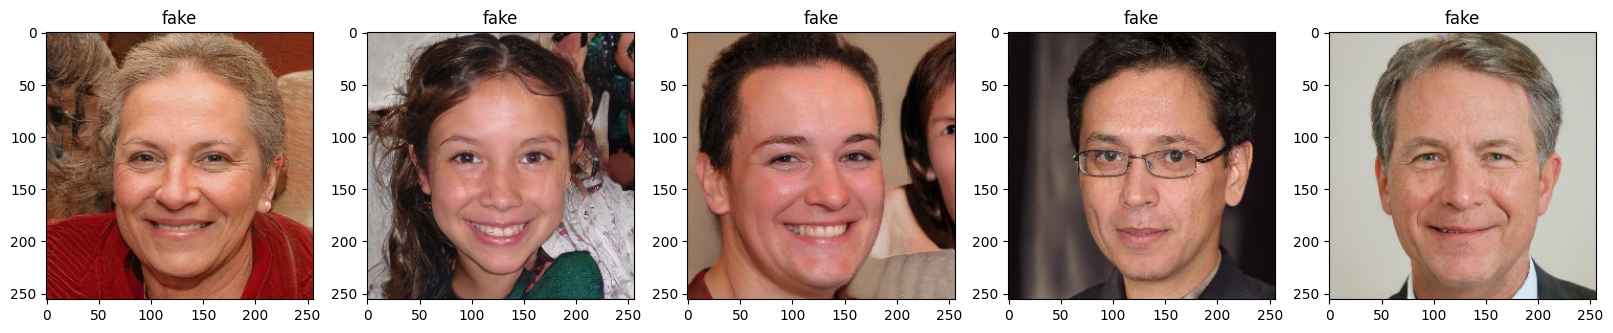

In [18]:
# !python -m pip install --upgrade pip setuptools wheel
# !python -m pip install lbry-libtorrent
# !apt install python3-libtorrent
import os
import random

plt.figure(figsize=(20,20))

ex_fake_folder = r'/content/real_vs_fake/real-vs-fake/test/fake'
ex_real_folder = r"/content/real_vs_fake/real-vs-fake/test/real"
IMG_WIDTH = 224
IMG_HEIGHT = 224

for i in range(5):
    file = random.choice(os.listdir(ex_fake_folder))
    image_path = os.path.join(ex_fake_folder, file)
    img = plt.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text('fake')
    plt.imshow(img)


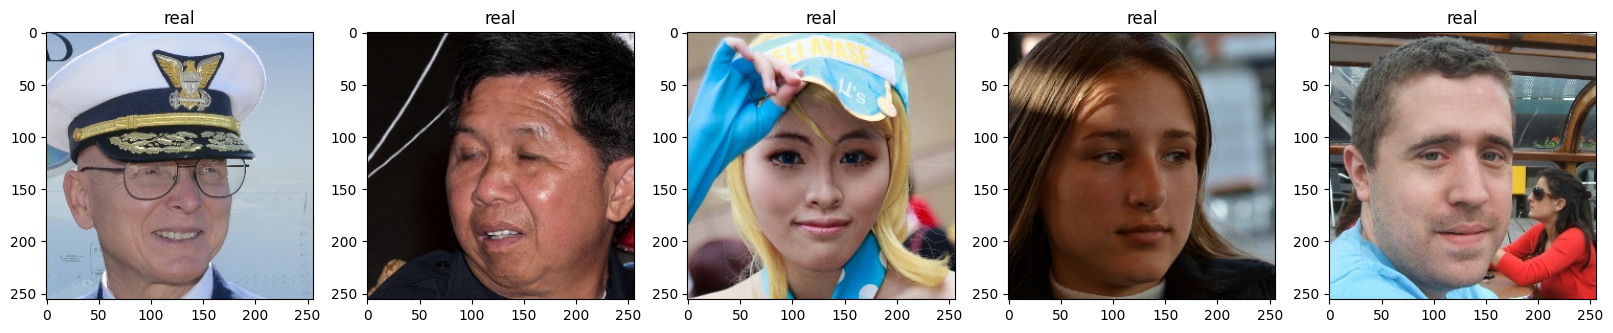

In [19]:
plt.figure(figsize=(20,20))

for i in range(5):
    file = random.choice(os.listdir(ex_real_folder))
    image_path = os.path.join(ex_real_folder, file)
    img = plt.imread(image_path)
    ax1=plt.subplot(1,5,i+1)
    ax1.title.set_text('real')
    plt.imshow(img)

In [20]:
'''source: https://vijayabhaskar96.medium.com/
tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720'''
'''one thing to note is you have to set shuffle=False for the test batch. This is because the
labels get shifted and you can't predict correctly without it. It's super weird and I should've
just created my own code instead of relying on Keras's generative methods'''

image_gen = ImageDataGenerator()

train = image_gen.flow_from_directory(
  '/content/real_vs_fake/real-vs-fake/train',
    class_mode='binary',
    shuffle=True,
    target_size=(224,224),
    batch_size=64
)

valid = image_gen.flow_from_directory(
    '/content/real_vs_fake/real-vs-fake/valid',
    class_mode='binary',
    shuffle=True,
    target_size=(224,224),
    batch_size=64
)
test = image_gen.flow_from_directory(
    '/content/real_vs_fake/real-vs-fake/test',
    class_mode='binary',
    shuffle=False,
    target_size=(224,224),
    batch_size=1
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [21]:
new_input = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3))
mobilenet_model = MobileNetV3Small(include_top = False,weights='imagenet', input_tensor = new_input, classes = 2)
mobilenet_model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)          

In [22]:
for layer in mobilenet_model.layers:
    layers.trainable = False

model = Sequential()
model.add(mobilenet_model)
model.add(layers.Flatten())
model.add(layers.Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 2)                 56450     
                                                                 
Total params: 995570 (3.80 MB)
Trainable params: 983458 (3.75 MB)
Non-trainable params: 12112 (47.31 KB)
_________________________________________________________________


In [60]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.1
    Uninstalling ml-dtypes-0.3.1:
      Successfully uninstalled ml-dtyp

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
optimizer=optimizers.Adam(learning_rate=5e-5),
metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5)
mobile_history=model.fit(
    train,
    epochs=5,
    validation_data=valid,
    verbose=1
)

Epoch 1/5
1563/1563 [==============================] - 380s 214ms/step - loss: 0.2967 - accuracy: 0.8831 - val_loss: 0.1595 - val_accuracy: 0.9381
Epoch 2/5
1563/1563 [==============================] - 322s 206ms/step - loss: 0.0730 - accuracy: 0.9725 - val_loss: 0.1177 - val_accuracy: 0.9578
Epoch 3/5
1563/1563 [==============================] - 304s 194ms/step - loss: 0.0316 - accuracy: 0.9893 - val_loss: 0.0567 - val_accuracy: 0.9784
Epoch 4/5
1563/1563 [==============================] - 290s 185ms/step - loss: 0.0148 - accuracy: 0.9955 - val_loss: 0.0640 - val_accuracy: 0.9776
Epoch 5/5
1563/1563 [==============================] - 288s 184ms/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.0494 - val_accuracy: 0.9844


In [ ]:
# /content/mobilenet_model
mobilenet_model.save('/content/model/mobilenet_model.h5',save_format="h5")
#  simple_model.save('/content/model/simple_model',save_format="h5")


In [24]:
y_pred = model.predict(test)
y_pred = np.argmax(y_pred, axis=1)
y_test = test.classes
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred > 0.5))

20000/20000 [==============================] - 162s 8ms/step
AP Score: 0.9710870242555708
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10000
           1       0.98      0.99      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



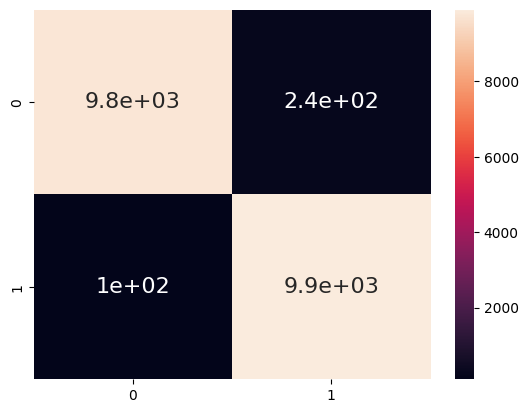

In [25]:
cm = metrics.confusion_matrix(test.classes, y_pred)
sns.heatmap(pd.DataFrame(cm), annot=True, annot_kws={"size": 16})
plt.show()

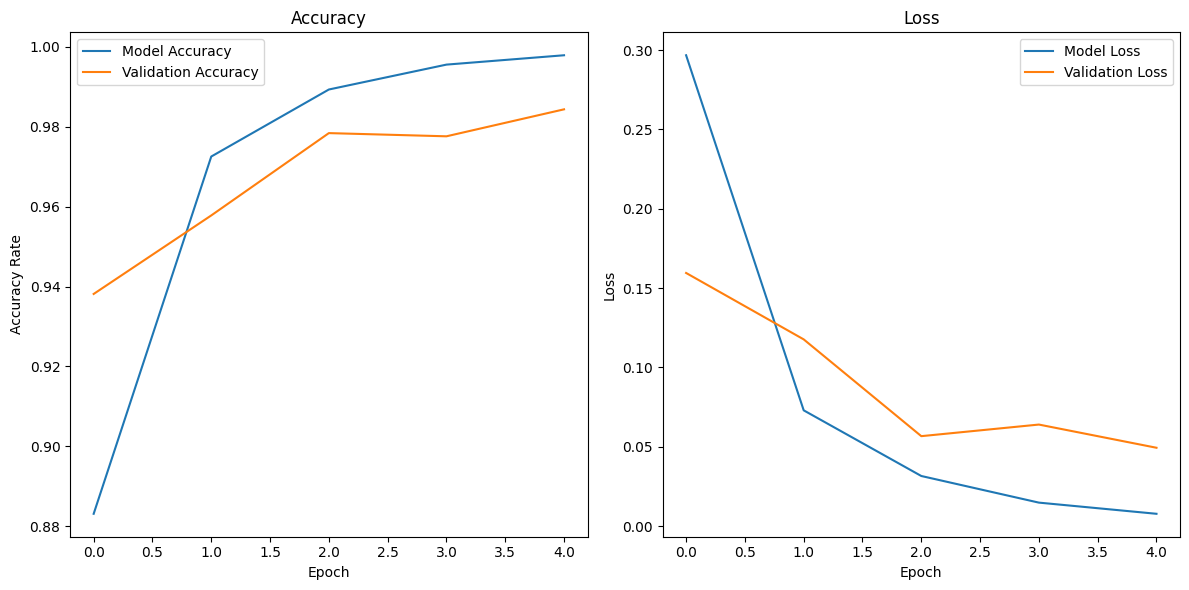

In [26]:

import matplotlib.pyplot as plt

# Assuming you have already defined simple_history and it contains the necessary data

# Create a figure with two separate graphs for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Model and Validation Accuracy
ax1.plot(mobile_history.history['accuracy'], label='Model Accuracy')
ax1.plot(mobile_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy Rate')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot Model and Validation Loss
ax2.plot(mobile_history.history['loss'], label='Model Loss')
ax2.plot(mobile_history.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure with two separate graphs
plt.show()
